## Домашние задания

1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.)  

В этом блокноте реализованы следующие критерии останова: 

* минимальное количество объектов в листе - `min_samples_leaf`, 
* максимальная глубина дерева - `max_depth`,
* максимальное число листьев - `max_leaves`.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
classification_data, classification_labels = datasets.make_classification(n_samples=100, 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5
                                                                         )

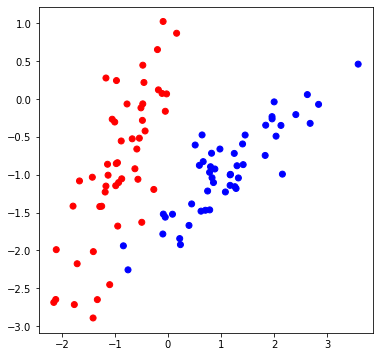

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)
train_data.shape

(70, 2)

In [5]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        #prediction = max(classes, key=classes.get)
        # найдем вероятность встретить класс 1 в листе
        try:
            prediction = classes[1] / (sum(classes.values()))
        except:
            prediction = 0
        return prediction 

In [7]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [20]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels, min_samples_leaf=1):
    # min_samples_leaf - минимальное количество объектов в узле
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_samples_leaf объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [21]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, min_samples_leaf=1, 
               max_depth=None, depth=0, 
               max_leaves=1000):
    
    quality, t, index = find_best_split(data, labels, min_samples_leaf)
    
    global counter_leaf # счетчик листьев
    global counter_node # счетчик узлов
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        counter_leaf += 1
        print('== stop: quality - ', counter_leaf, ' leaf')
        return Leaf(data, labels)
    #  Прекращаем рекурсию, когда достигли заданной глубины дерева
    if (max_depth is not None) and (depth >= max_depth):
        counter_leaf += 1
        print('== stop: max_depth - ', counter_leaf, ' leaf')
        return Leaf(data, labels)
    
    if max_leaves is not None:
        if (counter_leaf <= (max_leaves)) and (counter_node + 1) <= (max_leaves / 2):

            print('-------split-------')
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            counter_node += 1

            # Вывод для проверки
            if depth == 0: print('level', depth, ': ', len(data))
            depth += 1 # текущий уровень дерева
            print('level', depth, ': ', len(true_data), ' + ', len(false_data))

            # Рекурсивно строим два поддерева
            true_branch = build_tree(true_data, true_labels, 
                                     min_samples_leaf, max_depth, depth, (max_leaves-counter_leaf))
            false_branch = build_tree(false_data, false_labels, 
                                      min_samples_leaf, max_depth, depth, (max_leaves-counter_leaf))
        elif (counter_leaf > max_leaves) or ((counter_node + 1) > (max_leaves / 2)):
            counter_leaf += 1
            print('== stop: max_leaves - ', counter_leaf, ' leaf')
            return Leaf(data, labels)
        
    else:
        print('-------split-------')
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        counter_node += 1
        
        # Вывод для проверки
        if depth == 0: print('level', depth, ': ', len(data))
        depth += 1 # текущий уровень дерева
        print('level', depth, ': ', len(true_data), ' + ', len(false_data))
    
        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, 
                                 min_samples_leaf, max_depth, depth, max_leaves)
        false_branch = build_tree(false_data, false_labels, 
                                  min_samples_leaf, max_depth, depth, max_leaves)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted, threshold=0.5):
    # для вероятностей
    predicted = np.array(predicted)
    predicted = np.squeeze(np.where([predicted > threshold], 1, 0))
    
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [39]:
# Построим дерево по обучающей выборке
counter_leaf = 0 # счетчик листьев
counter_node = 0 # счетчик узлов
my_tree = build_tree(train_data, train_labels, min_samples_leaf=10, max_depth=None, max_leaves=None)
print('Количество листьев - ', counter_leaf)
print('Количество узлов - ', counter_node)
print('========tree========')
print_tree(my_tree)
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

-------split-------
level 0 :  70
level 1 :  40  +  30
-------split-------
level 2 :  12  +  28
== stop: quality -  1  leaf
== stop: quality -  2  leaf
== stop: quality -  3  leaf
Количество листьев -  3
Количество узлов -  2
========tree========
Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Прогноз: 0.4166666666666667
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1.0


In [31]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [32]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

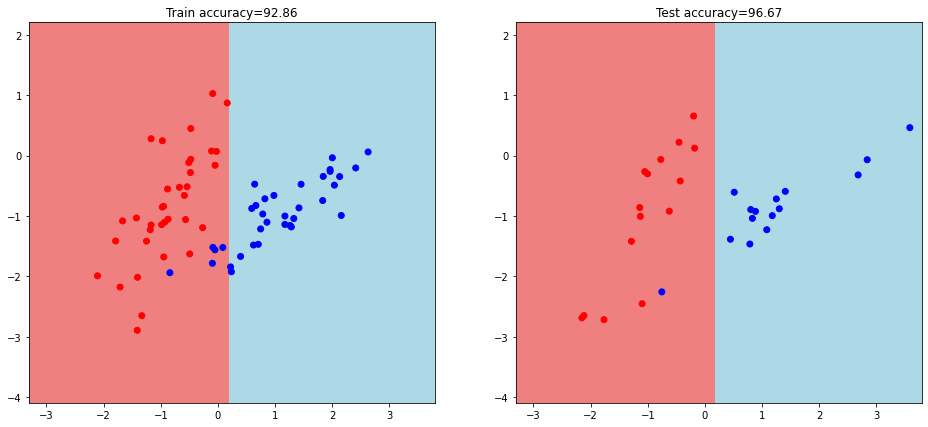

In [33]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}');